In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from xgboost import XGBClassifier
from sklearn import metrics

In [2]:
df=pd.read_csv("churn.csv")

In [3]:
df.head()

state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...    total eve calls  total eve charge  \
0             45.07  ...                 99             16.78   
1             27.47  ...                103             16.62   
2             41.38  ...                110             10.30   
3             50.90  ...                 88              5.26   
4             28.34  ...                122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

In [4]:
g = df.columns.to_series().groupby(df.dtypes).groups
{k.name: v for k, v in g.items()}

{'bool': Index(['churn'], dtype='object'),
 'int64': Index(['account length', 'area code', 'number vmail messages',
        'total day calls', 'total eve calls', 'total night calls',
        'total intl calls', 'customer service calls'],
       dtype='object'),
 'float64': Index(['total day minutes', 'total day charge', 'total eve minutes',
        'total eve charge', 'total night minutes', 'total night charge',
        'total intl minutes', 'total intl charge'],
       dtype='object'),
 'object': Index(['state', 'phone number', 'international plan', 'voice mail plan'], dtype='object')}

In [5]:
df['area code'] = df['area code'].astype(object)

In [6]:
categorical_features = df.select_dtypes(include=['object','bool']).columns.tolist()
categorical_features

['state',
 'area code',
 'phone number',
 'international plan',
 'voice mail plan',
 'churn']

In [7]:
continuous_features  = df.select_dtypes(include=['number']).columns.tolist()

In [8]:
#Convert categorical features to numerical
def encoding(df,categorical_features):
    
    df_cat = df[categorical_features]
    #By defaault, convert all the categories to numerical forms using Label encoder
    le = {}
    for i in range(len(df_cat.columns.tolist())):
        le[i] = LabelEncoder()
        df_cat.iloc[:,i] = le[i].fit_transform(df_cat.iloc[:,i].astype(str))

    return df_cat

In [9]:
encoded_data  = encoding(df,categorical_features)
data          = pd.concat([df[continuous_features],encoded_data],axis=1)
print('Encoded data looks like this: \n',data.head())

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Encoded data looks like this: 
    account length  number vmail messages  total day minutes  total day calls  \
0             128                     25              265.1              110   
1             107                     26              161.6              123   
2             137                      0              243.4              114   
3              84                      0              299.4               71   
4              75                      0              166.7              113   

   total day charge  total eve minutes  total eve calls  total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   total night minutes  

In [10]:
data.shape

(3333, 21)

In [11]:
data.describe().T

count         mean         std    min     25%  \
account length          3333.0   101.064806   39.822106   1.00   74.00   
number vmail messages   3333.0     8.099010   13.688365   0.00    0.00   
total day minutes       3333.0   179.775098   54.467389   0.00  143.70   
total day calls         3333.0   100.435644   20.069084   0.00   87.00   
total day charge        3333.0    30.562307    9.259435   0.00   24.43   
total eve minutes       3333.0   200.980348   50.713844   0.00  166.60   
total eve calls         3333.0   100.114311   19.922625   0.00   87.00   
total eve charge        3333.0    17.083540    4.310668   0.00   14.16   
total night minutes     3333.0   200.872037   50.573847  23.20  167.00   
total night calls       3333.0   100.107711   19.568609  33.00   87.00   
total night charge      3333.0     9.039325    2.275873   1.04    7.52   
total intl minutes      3333.0    10.237294    2.791840   0.00    8.50   
total intl calls        3333.0     4.479448    2.461214   0.00    3.00   
total intl charge       3333.0     2.764581    0.753773   0.00    2.30   
customer service calls  3333.0     1.562856    1.315491   0.00    1.00   
state                   3333.0    26.059406   14.824911   0.00   14.00   
area code               3333.0     1.000600    0.709649   0.00    0.00   
phone number            3333.0  1666.000000  962.298550   0.00  833.00   
international plan      3333.0     0.096910    0.295879   0.00    0.00   
voice mail plan         3333.0     0.276628    0.447398   0.00    0.00   
churn                   3333.0     0.144914    0.352067   0.00    0.00   

                            50%      75%      max  
account length           101.00   127.00   243.00  
number vmail messages      0.00    20.00    51.00  
total day minutes        179.40   216.40   350.80  
total day calls          101.00   114.00   165.00  
total day charge          30.50    36.79    59.64  
total eve minutes        201.40   235.30   363.70  
total eve calls          100.00   114.00   170.00  
total eve charge          17.12    20.00    30.91  
total night minutes      201.20   235.30   395.00  
total night calls        100.00   113.00   175.00  
total night charge         9.05    10.59    17.77  
total intl minutes        10.30    12.10    20.00  
total intl calls           4.00     6.00    20.00  
total intl charge          2.78     3.27     5.40  
customer service calls     1.00     2.00     9.00  
state                     26.00    39.00    50.00  
area code                  1.00     2.00     2.00  
phone number            1666.00  2499.00  3332.00  
international plan         0.00     0.00     1.00  
voice mail plan            0.00     1.00     1.00  
churn                      0.00     0.00     1.00

In [12]:
scaler = StandardScaler()
df=pd.DataFrame(scaler.fit_transform(data.iloc[:,:-1]),columns=df.columns[:-1])

In [13]:
df['churn']=data['churn']

In [14]:
df.head()

state  account length  area code  phone number  international plan  \
0  0.676489        1.234883   1.566767      0.476643            1.567036   
1  0.149065        1.307948  -0.333738      1.124503           -0.334013   
2  0.902529       -0.591760   1.168304      0.675985            1.168464   
3 -0.428590       -0.591760   2.196596     -1.466936            2.196759   
4 -0.654629       -0.591760  -0.240090      0.626149           -0.240041   

   voice mail plan  number vmail messages  total day minutes  total day calls  \
0        -0.070610              -0.055940          -0.070427         0.866743   
1        -0.108080               0.144867          -0.107549         1.058571   
2        -1.573383               0.496279          -1.573900        -0.756869   
3        -2.742865              -0.608159          -2.743268        -0.078551   
4        -1.038932               1.098699          -1.037939        -0.276311   

   total day charge  ...    total eve calls  total eve charge  \
0         -0.465494  ...          -0.085008         -0.601195   
1          0.147825  ...           1.240482         -0.601195   
2          0.198935  ...           0.703121          0.211534   
3         -0.567714  ...          -1.303026          1.024263   
4          1.067803  ...          -0.049184         -0.601195   

   total night minutes  total night calls  total night charge  \
0            -0.085690          -0.427932           -0.678649   
1             1.241169          -0.427932            0.603170   
2             0.697156          -1.188218            0.333313   
3            -1.306401           0.332354            0.603170   
4            -0.045885           1.092641            0.670634   

   total intl minutes  total intl calls  total intl charge  \
0           -0.000846          0.270227          -0.327580   
1           -0.000846         -0.094579          -0.327580   
2           -0.000846         -0.570595          -0.327580   
3           -1.410205          0.042613           3.052685   
4           -0.000846         -1.617204           3.052685   

   customer service calls  churn  
0                1.617086      0  
1                1.617086      0  
2               -0.618396      0  
3               -0.618396      0  
4               -0.618396      0  

[5 rows x 21 columns]

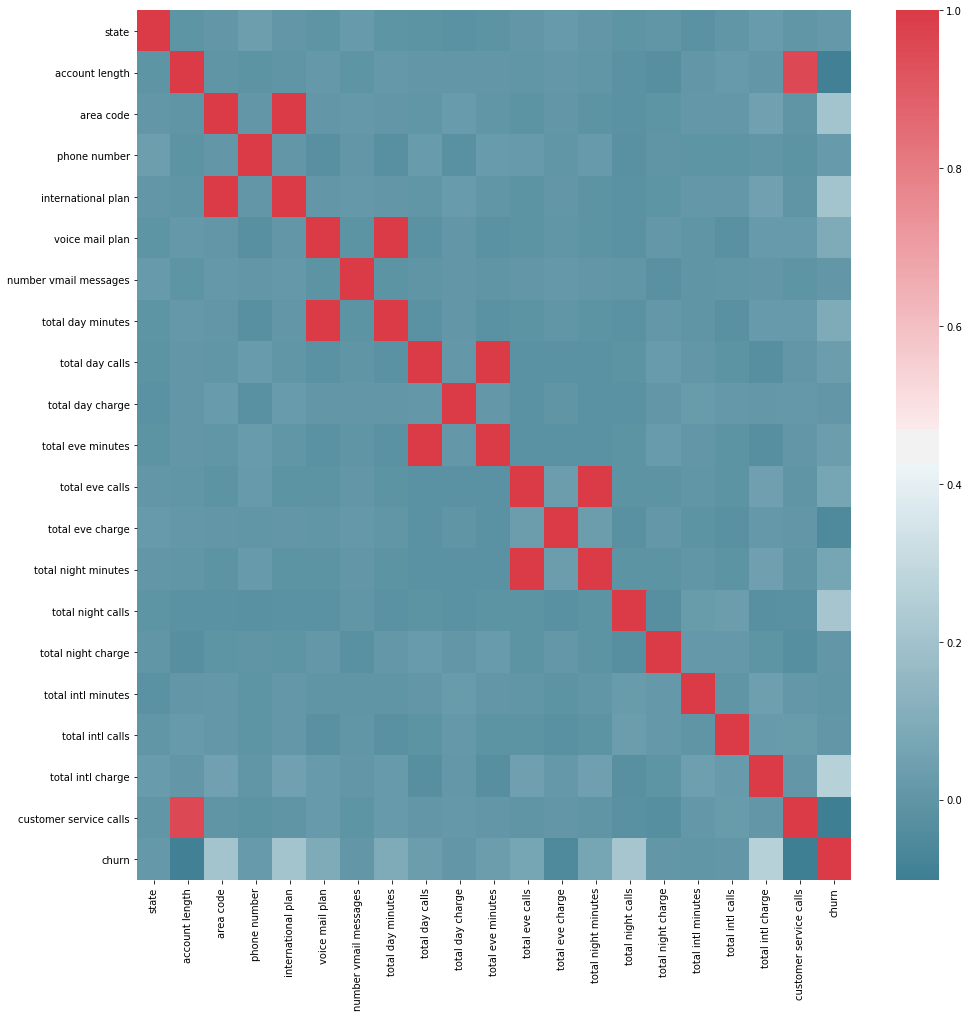

In [15]:
corr = df.corr()
# Plot figsize
fig, ax = plt.subplots(figsize=(16,16))
# Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Drop self-correlations
#dropSelf = np.zeros_like(corr)
#dropSelf[np.triu_indices_from(dropSelf)] = True
# Generate heatmap with mask on redundant values with a precision of 2 
sns.heatmap(corr, cmap=colormap)#, mask=dropSelf


In [16]:
X = data.loc[:, data.columns != 'churn']
Y = data['churn']
sss= StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# equating the index of all the shuffled index to the data.
for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]            
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index] 
print('Classification: Train-Test split done successfully using StratifiedShuffleSplit.')

Classification: Train-Test split done successfully using StratifiedShuffleSplit.


In [17]:
len(X_test)

667

In [57]:
clf = XGBClassifier(n_estimators=100)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [58]:
y_pred=clf.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [59]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9475262368815592


In [60]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97       570
          1       0.94      0.68      0.79        97

avg / total       0.95      0.95      0.94       667

